In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import glob
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from lib.uti import get_f_name, list_duplicates
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
np.set_printoptions(suppress=True)

annotation = './data/annotation.csv'
annot = pd.read_csv(annotation)

tem_f = get_f_name('./data/audio/Pitt/Control/')
tem_f_c = [i.split('.')[0] for i in tem_f]
id_c = list(dict.fromkeys(tem_f_c))
tem_f = get_f_name('./data/audio/Pitt/Dementia/')
tem_f_ad = [i.split('.')[0] for i in tem_f]
id_ad = list(dict.fromkeys(tem_f_ad))
data = {'ComParE':'./FE/ComParE_a_l.csv','eGeMAPS':'./FE/eGeMAPS_a_l.csv','emobase':'./FE/emobase_a_l.csv','surfboard':'./data/surfboard3.csv'}
processed_df_path = './FE/ML_al/'

In [2]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier, Pool
# catboost xgboost lightboost
from sklearn.metrics import roc_auc_score,recall_score,precision_score,accuracy_score
from sklearn.model_selection import StratifiedKFold, KFold

In [35]:
Feature_set = ['ComParE','eGeMAPS','emobase','surfboard'][1]

In [4]:
df = pd.read_csv(data[Feature_set])

In [87]:
df.isnull().sum(axis = 0).sort_values()

Unnamed: 0                              0
chroma_stft_std_8                       0
chroma_stft_std_9                       0
chroma_stft_std_10                      0
chroma_stft_std_11                      0
                                       ..
log_melspec_first_derivative_std_122    0
log_melspec_first_derivative_std_123    0
log_melspec_first_derivative_std_104    0
label                                   0
hnr                                     1
Length: 2789, dtype: int64

In [88]:
df = df.drop(columns=['hnr'])

In [89]:
cor_matrix = df[df.columns[3:]].corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))
drop_col = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(len(drop_col))
df_ = df.drop(columns=drop_col)
df_.to_csv(processed_df_path+Feature_set+'.csv',index=False)

1672


Evaluation

In [36]:
df_ = pd.read_csv(processed_df_path+Feature_set+'.csv')

In [37]:
X = df_.iloc[:,3:].to_numpy().astype(np.float32)
def label(r, id_ad):
    if os.path.basename(r).split('_')[0] in id_ad:return 1
    return 0
y = df.file.apply(lambda r: label(r, id_ad))

In [ ]:
X = df_.iloc[:,2:-1].to_numpy().astype(np.float32)
y = df_.iloc[:,-1].to_numpy().astype(np.float32)

In [50]:
clfs = {
    'SVM-linear':SVC(kernel="linear", C=0.1),
    'SVM-rbf':SVC(kernel='rbf', gamma='scale', C=1),
    #'GP':GaussianProcessClassifier(1.0 * RBF(1.0)),
    'DT': DecisionTreeClassifier(max_depth=20,criterion='gini'),
    'RF':RandomForestClassifier(max_depth=20, n_estimators=200),
    'KNN': KNeighborsClassifier(n_neighbors=100),
    'MLP':MLPClassifier(activation='relu',hidden_layer_sizes=1000,learning_rate_init=0.002,solver='adam', max_iter=2000),
    'LDA':LinearDiscriminantAnalysis(),
    'Cat': CatBoostClassifier(iterations=150,
                              depth=8,
                              learning_rate=0.1,
                              bootstrap_type=['MVS','Bayesian'][1],
                              loss_function=['Logloss','CrossEntropy','MultiClass'][0],
                              verbose=False)
    }

In [38]:
id_list = df.file.apply(lambda s: os.path.basename(s).split('_')[0]).values
#id_list = df.path.apply(lambda s: os.path.basename(s).split('_')[0]).values
selected_id = np.load('./data/selected_id.npy') 
selected_id = np.delete(selected_id , np.where(selected_id  == 172))
tr_idx, t_idx = train_test_split(selected_id, test_size=0.2)
selected_idx_tr = [idx for idx,i in enumerate(id_list) if int(i.split('-')[0]) in tr_idx]
selected_idx_t  = [idx for idx,i in enumerate(id_list) if int(i.split('-')[0]) in t_idx]
print('segments num:', len(selected_idx_tr), len(selected_idx_t))
print('subjects num:', len(set(tr_idx)), len(set(t_idx)))

segments num: 331 89
subjects num: 159 40


In [39]:
X_tr, y_tr = X[selected_idx_tr], y[selected_idx_tr]
X_t, y_t   = X[selected_idx_t],  y[selected_idx_t]

In [40]:
clf = clfs['RF']

In [41]:
clf.fit(X_tr, y_tr)

RandomForestClassifier(max_depth=20, n_estimators=200)

In [72]:
clf.fit(X, y)

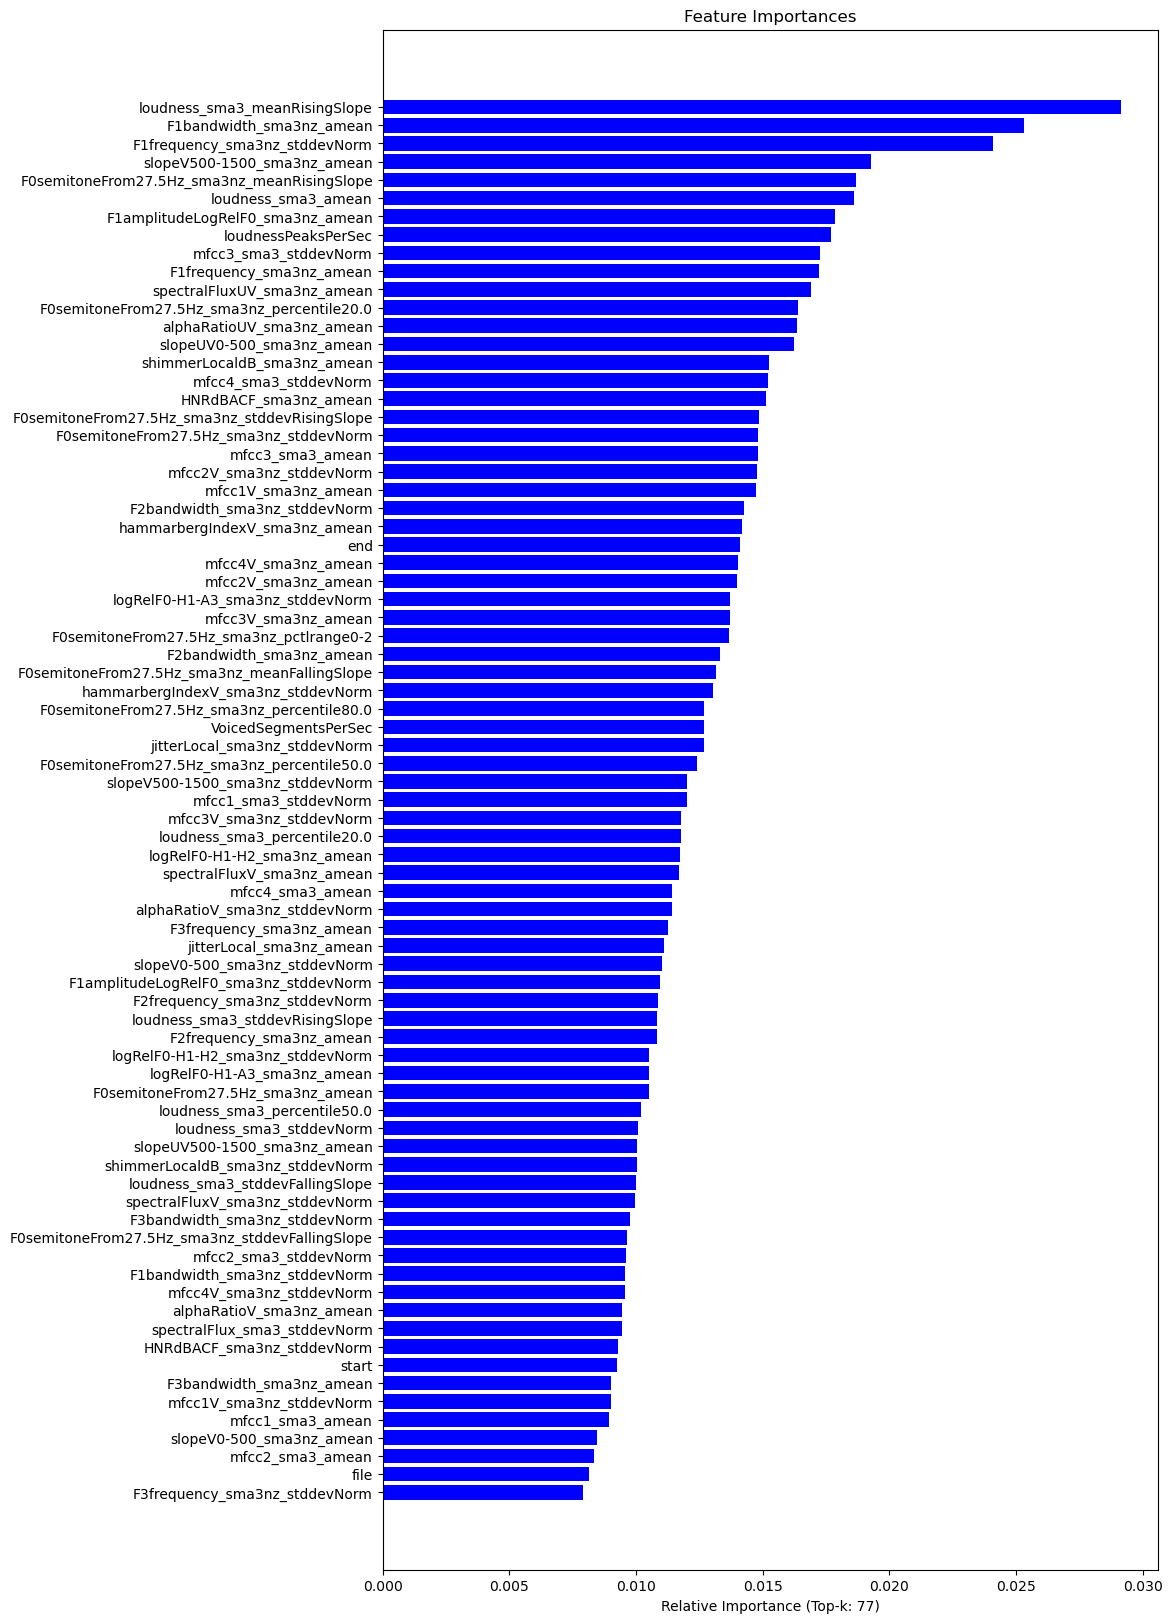

In [42]:
top_k = 100
if X.shape[1]< top_k:
    top_k = X.shape[1]
features = df_.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[-top_k:] 
plt.figure(figsize=(10, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance (Top-k: {})'.format(top_k))
plt.show()

In [38]:
clf.best_score_

{'learn': {'Logloss': 0.03727670149739486}}

In [202]:
y_pre = clf.predict(X_t)

In [204]:
print(classification_report(y_t, y_pre, target_names=['Control', 'AD']))

              precision    recall  f1-score   support

     Control       0.76      0.52      0.61        66
          AD       0.42      0.68      0.52        34

    accuracy                           0.57       100
   macro avg       0.59      0.60      0.56       100
weighted avg       0.64      0.57      0.58       100



In [43]:
X_select = X[...,sorted(indices)]

In [64]:
X_select = X

In [206]:
id_list = df_.path.apply(lambda s: os.path.basename(s).split('_')[0]).values
selected_id = np.load('./data/selected_id.npy') 
selected_id = np.delete(selected_id , np.where(selected_id  == 172))
tr_idx, t_idx = train_test_split(selected_id, test_size=0.3)
selected_idx_tr = [idx for idx,i in enumerate(id_list) if int(i.split('-')[0]) in tr_idx]
selected_idx_t  = [idx for idx,i in enumerate(id_list) if int(i.split('-')[0]) in t_idx]
print('segments num:', len(selected_idx_tr), len(selected_idx_t))
print('subjects num:', len(set(tr_idx)), len(set(t_idx)))
X_tr, y_tr = X_select[selected_idx_tr], y[selected_idx_tr]
X_t, y_t   = X_select[selected_idx_t],  y[selected_idx_t]

segments num: 291 129
subjects num: 139 60


In [211]:
clf = make_pipeline(StandardScaler(), clfs['RF'])
clf.fit(X_tr, y_tr)

y_pre = clf.predict(X_t)
print(classification_report(y_t, y_pre, target_names=['Control', 'AD']))

              precision    recall  f1-score   support

     Control       0.60      0.65      0.62        60
          AD       0.67      0.62      0.65        69

    accuracy                           0.64       129
   macro avg       0.64      0.64      0.64       129
weighted avg       0.64      0.64      0.64       129



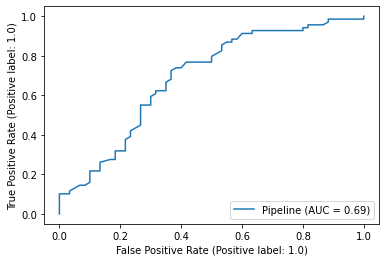

In [212]:
from sklearn.metrics import plot_roc_curve
%matplotlib inline
plot_roc_curve(clf, X_t, y_t)  
plt.show()

In [51]:
skf = KFold(n_splits = 5, shuffle=True)
selected_id = np.load('./data/selected_id.npy') 
selected_id = np.delete(selected_id , np.where(selected_id  == 172))
list_acc = []
for tr_idx, t_idx in skf.split(selected_id):
    selected_idx_tr = [idx for idx,i in enumerate(id_list) if int(i.split('-')[0]) in selected_id[tr_idx]]
    selected_idx_t  = [idx for idx,i in enumerate(id_list) if int(i.split('-')[0]) in selected_id[t_idx]]
    #print('segments num:', len(selected_idx_tr), len(selected_idx_t))
    #print('subjects num:', len(set(tr_idx)), len(set(t_idx)))

    X_tr, y_tr = X_select[selected_idx_tr], y[selected_idx_tr]
    X_t,  y_t  = X_select[selected_idx_t],  y[selected_idx_t]

    clf = make_pipeline(StandardScaler(), clfs['Cat'])
    clf.fit(X_tr, y_tr)
    print('-----------------')
    y_pre = clf.predict(X_t)
    list_acc.append(accuracy_score(y_t, y_pre))

-----------------
-----------------
-----------------
-----------------
-----------------


In [ ]:
Feature_set

In [52]:
sum(list_acc)/len(list_acc)

0.6083441558441558

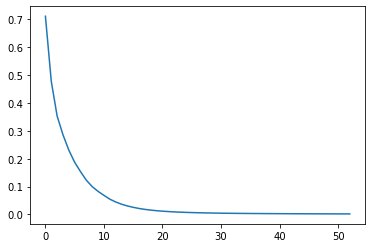

In [195]:
plt.plot(range(len(clfs['MLP'].loss_curve_)),clfs['MLP'].loss_curve_)
plt.show()

In [196]:
len(clfs['MLP'].loss_curve_)

53